In [16]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
from matplotlib import style
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
pybamm.set_logging_level("NOTICE")

import pybamm.input
import pybamm.input.parameters
import pybamm.input.parameters.lithium_ion.Prada2013

### Test data loading Function

In [17]:
from pathlib import Path
import pandas as pd

from pathlib import Path
import pandas as pd

def get_test_data(excel_name, sheet_name):
    try:
        BASE_DIR = Path(__file__).resolve().parent
    except NameError:
        BASE_DIR = Path.cwd()

    excel_path = BASE_DIR / f"{excel_name}.xlsx"

    if not excel_path.exists():
        raise FileNotFoundError(f"Excel file not found: {excel_path}")

    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    return df


# df1 = get_test_data("beginning_of_life", "Discharge")
# print(df1.head())


In [18]:
model = pybamm.lithium_ion.SPM(
    {
        "open-circuit potential": ("current sigmoid", "current sigmoid"),
    }
)
params = pybamm.ParameterValues("Prada2013")    


In [ ]:
params.update({
        # cell
        "Negative electrode thickness [m]": 3.4e-05,
        "Separator thickness [m]": 2.5e-05,
        "Positive electrode thickness [m]": 8e-05,
        "Electrode height [m]": 0.6, 
        "Electrode width [m]": 0.3,  
        "Nominal cell capacity [A.h]": 2.3+0.2,
        "Current function [A]": 2.3+0.2,
        "Contact resistance [Ohm]": 0,
        # negative electrode
        "Negative electrode conductivity [S.m-1]": 215.0,
        "Maximum concentration in negative electrode [mol.m-3]": 30555,
        "Negative particle diffusivity [m2.s-1]": 3e-15,

        "Negative electrode lithiation OCP [V]": pybamm.input.parameters.lithium_ion.Prada2013.graphite_LGM50_ocp_Chen2020_lithiation,
        "Negative electrode delithiation OCP [V]":pybamm.input.parameters.lithium_ion.Prada2013.graphite_LGM50_ocp_Chen2020_delithiation,
        
        "Negative electrode porosity": 0.36,
        "Negative electrode active material volume fraction": 0.58,
        "Negative particle radius [m]": 5e-6,
        "Negative electrode Bruggeman coefficient (electrolyte)": 1.5,
        "Negative electrode Bruggeman coefficient (electrode)": 1.5,
        "Negative electrode charge transfer coefficient": 0.5,
        "Negative electrode double-layer capacity [F.m-2]": 0.2,
        "Negative electrode exchange-current density [A.m-2]": pybamm.input.parameters.lithium_ion.Prada2013.graphite_LGM50_electrolyte_exchange_current_density_Chen2020,
        "Negative electrode OCP entropic change [V.K-1]": 0,
        # positive electrode
        "Positive electrode conductivity [S.m-1]": 0.33795074,
        "Maximum concentration in positive electrode [mol.m-3]": 22806.0,
        "Positive particle diffusivity [m2.s-1]": 5.9e-18,
        
        "Positive electrode delithiation OCP [V]": pybamm.input.parameters.lithium_ion.Prada2013.LFP_ocp_Afshar2017_delithiation,
        "Positive electrode lithiation OCP [V]": pybamm.input.parameters.lithium_ion.Prada2013.LFP_ocp_Afshar2017_lithiation,
        
        
        "Positive electrode porosity": 0.426,
        "Positive electrode active material volume fraction": 0.374,
        "Positive particle radius [m]": 5e-08,
        "Positive electrode Bruggeman coefficient (electrode)": 1.5,
        "Positive electrode Bruggeman coefficient (electrolyte)": 1.5,
        "Positive electrode charge transfer coefficient": 0.5,
        "Positive electrode double-layer capacity [F.m-2]": 0.2,
        "Positive electrode exchange-current density [A.m-2]": pybamm.input.parameters.lithium_ion.Prada2013.LFP_electrolyte_exchange_current_density_kashkooli2017,
        "Positive electrode OCP entropic change [V.K-1]": 0,
        # separator
        "Separator porosity": 0.45,
        "Separator Bruggeman coefficient (electrolyte)": 1.5,
        # electrolyte
        "Initial concentration in electrolyte [mol.m-3]": 1200.0,
        "Cation transference number": 0.36,
        "Thermodynamic factor": 1.0,
        "Electrolyte diffusivity [m2.s-1]": 2e-10,
        "Electrolyte conductivity [S.m-1]": pybamm.input.parameters.lithium_ion.Prada2013.electrolyte_conductivity_Prada2013,
        # experiment
        "Reference temperature [K]": 298,
        "Ambient temperature [K]": 298,
        "Number of electrodes connected in parallel to make a cell": 1.0,
        "Number of cells connected in series to make a battery": 1.0,
        "Lower voltage cut-off [V]": 2.5,
        "Upper voltage cut-off [V]": 3.5,
        "Open-circuit voltage at 0% SOC [V]": 2.5,
        "Open-circuit voltage at 100% SOC [V]": 3.5,

        # "Initial concentration in negative electrode [mol.m-3]": 0.81 * 30555,
        "Initial concentration in positive electrode [mol.m-3]": 0.0038 * 22806,
        "Initial temperature [K]": 298,
        
        }, check_already_exists=False
        )


params.update(
    {
        "Negative particle diffusivity [m2.s-1]": 3e-13,
        "Positive particle diffusivity [m2.s-1]": 5.9e-18,
        "Positive particle radius [m]": 5e-08,
        
        "Negative electrode thickness [m]": 3.4e-05*1.22,
        "Initial concentration in negative electrode [mol.m-3]": (0.81 * 30555*0.9),
        "Maximum concentration in negative electrode [mol.m-3]": 30555*1.1,

    }, check_already_exists=False
)

In [31]:
# exp = pybamm.Experiment(
#     [
#         "Discharge at C/10 for 10 hours or until 2.5V (1 seconds period)",
#     ]
# )

exp = pybamm.Experiment(
    [
        (
            "Discharge at 0.5A until 2.5V (1 seconds period)",
            "Rest for 30 minutes (10 seconds period)",
            "Charge at 2.5A until 3.5V (1 seconds period)",
            "Hold at 3.5V until 0.05A (1 seconds period)"
        )
    ]
)
solver = pybamm.IDAKLUSolver()

sim = pybamm.Simulation(model= model, parameter_values=params, experiment=exp, solver=solver)
# sol = sim.solve(initial_soc=1.0)
sol = sim.solve(calc_esoh=False)
sol.plot()

2025-12-23 16:06:11.454 - [NOTICE] logger.func(7): Cycle 1/1 (16.200 us elapsed) --------------------
2025-12-23 16:06:11.456 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 0.5A until 2.5V (1 seconds period)
2025-12-23 16:06:11.608 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 16:06:11.633 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 16:06:11.743 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 16:06:11.887 - [NOTICE] logger.func(7): Finish experiment simulation, took 432.184 ms


interactive(children=(FloatSlider(value=0.0, description='t', max=6.473400992763225, step=0.06473400992763226)…

2025-12-23 15:59:54.024 - [NOTICE] logger.func(7): Cycle 1/1 (11.800 us elapsed) --------------------
2025-12-23 15:59:54.024 - [NOTICE] logger.func(7): Cycle 1/1, step 1/1: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 15:59:54.099 - [NOTICE] logger.func(7): Finish experiment simulation, took 76.500 ms


N/P ratio at : 1.18503453038674
2.444986415103455
3.456238788573819


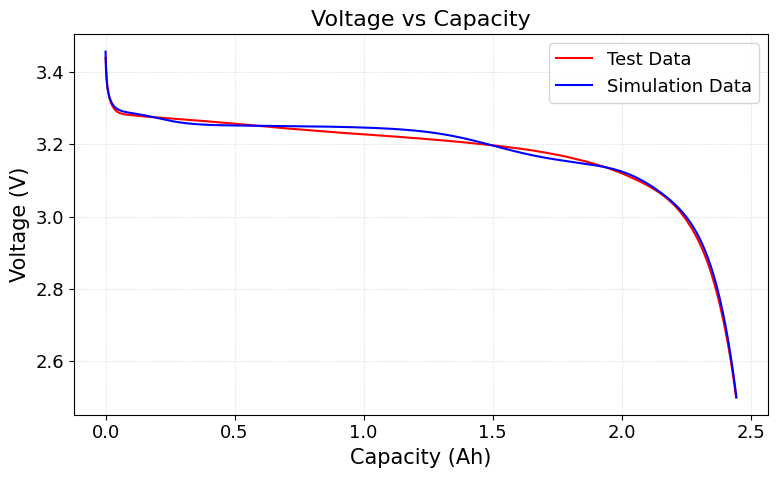

3.456238788573819


In [ ]:
### Test data
df = get_test_data("beginning_of_life", "Discharge")
test_voltage = df["1Ca Voltage [V]"].values
test_capacity = df["1Ca Capacity [Ah]"].values
####******************########

exp = pybamm.Experiment(
    [
        "Discharge at 2.5A until 2.5V (1 seconds period)",
    ]
)
solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(model= model, parameter_values=params, experiment=exp, solver=solver)
# sol = sim.solve(initial_soc=1.0)
sol = sim.solve(calc_esoh=False)

NE_cap = sol["Negative electrode capacity [A.h]"].entries[-1]
PE_cap = sol["Positive electrode capacity [A.h]"].entries[-1]
print("N/P ratio at", ":", NE_cap/PE_cap)


sim_cap = sol["Discharge capacity [A.h]"].entries - sol["Discharge capacity [A.h]"].entries[0]
print(sim_cap[-1])

sim_voltage = sol["Terminal voltage [V]"].entries
print(sim_voltage[0])

time = sol["Time [h]"].entries-sol["Time [h]"].entries[0]

plt.rcParams.update({
    "font.size": 14,          # base font size
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})

plt.figure(figsize=(8, 5))

plt.plot(test_capacity, test_voltage, color="red", linewidth=1.5, label="Test Data")
plt.plot(sim_cap, sim_voltage, color="blue", linestyle="-", linewidth=1.5, label="Simulation Data")

plt.xlabel("Capacity (Ah)")
plt.ylabel("Voltage (V)")
plt.title("Voltage vs Capacity")

plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

print(sim_voltage[0])

2025-12-23 15:59:54.446 - [NOTICE] logger.func(7): Cycle 1/1 (12.200 us elapsed) --------------------
2025-12-23 15:59:54.446 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 0.5A until 2.5V (1 seconds period)
2025-12-23 15:59:54.524 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 15:59:54.549 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 15:59:54.622 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 15:59:54.718 - [NOTICE] logger.func(7): Finish experiment simulation, took 268.935 ms


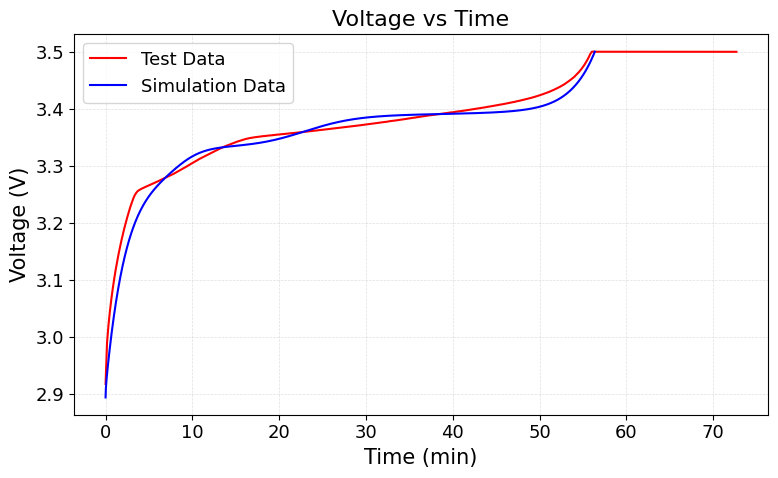

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# =======================
# Test data
# =======================
df = get_test_data("beginning_of_life", "Charge")
test_voltage = df["951 Voltage [V]"].values
test_time = df["951 Time [min]"].values

# =======================
# PyBaMM Simulation
# =======================
exp = pybamm.Experiment(
    [
        (
            "Discharge at 0.5A until 2.5V (1 seconds period)",
            "Rest for 30 minutes (10 seconds period)",
            "Charge at 2.5A until 3.5V (1 seconds period)",
            "Hold at 3.5V until 0.05A (1 seconds period)"
        )
    ]
)

solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(
    model=model,
    parameter_values=params,
    experiment=exp,
    solver=solver,
)

# sol = sim.solve(initial_soc=1.0)
sol = sim.solve(calc_esoh=False)

# sim_time_cc = sol.cycles[0].steps[2]["Time [min]"].entries - sol.cycles[0].steps[2]["Time [min]"].entries[0]
# sim_time_cv = sol.cycles[0].steps[3]["Time [min]"].entries - sol.cycles[0].steps[3]["Time [min]"].entries[0] + sim_time_cc[-1]

# sim_time = np.concatenate(
#     (sim_time_cc, sim_time_cv)
# )

sim_time = (
    sol.cycles[0].steps[2]["Time [min]"].entries
    - sol.cycles[0].steps[2]["Time [min]"].entries[0]
)

# sim_voltage_cc = sol.cycles[0].steps[2]["Terminal voltage [V]"].entries
# sim_voltage_cv = sol.cycles[0].steps[3]["Terminal voltage [V]"].entries

# sim_voltage = np.concatenate(
#     (sim_voltage_cc, sim_voltage_cv)
# )

sim_voltage = sol.cycles[0].steps[2]["Terminal voltage [V]"].entries


plt.rcParams.update({
    "font.size": 14,          # base font size
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})

plt.figure(figsize=(8, 5))

plt.plot(test_time, test_voltage, color="red", linewidth=1.5, label="Test Data")
plt.plot(sim_time, sim_voltage, color="blue", linestyle="-", linewidth=1.5, label="Simulation Data")

plt.xlabel("Time (min)")
plt.ylabel("Voltage (V)")
plt.title("Voltage vs Time")

plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


2025-12-23 15:59:54.959 - [NOTICE] logger.func(7): Cycle 1/1 (10.000 us elapsed) --------------------
2025-12-23 15:59:54.959 - [NOTICE] logger.func(7): Cycle 1/1, step 1/1: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 15:59:55.042 - [NOTICE] logger.func(7): Finish experiment simulation, took 80.732 ms


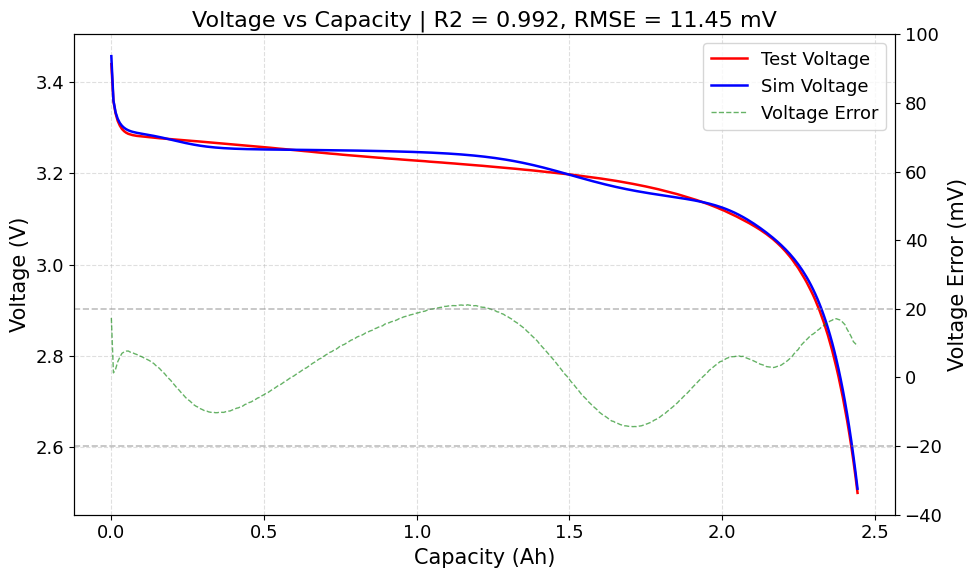

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# =======================
# Test data
# =======================
df = get_test_data("beginning_of_life", "Discharge")
test_voltage = df["1Ca Voltage [V]"].values
test_capacity = df["1Ca Capacity [Ah]"].values

# =======================
# PyBaMM Simulation
# =======================
exp = pybamm.Experiment(
    ["Discharge at 2.5A until 2.5V (1 seconds period)"]
)

solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(
    model=model,
    parameter_values=params,
    experiment=exp,
    solver=solver,
)

# sol = sim.solve(initial_soc=1.0)
sol = sim.solve(calc_esoh=False)

sim_cap = (
    sol["Discharge capacity [A.h]"].entries
    - sol["Discharge capacity [A.h]"].entries[0]
)
sim_voltage = sol["Terminal voltage [V]"].entries

# =======================
# Remove NaNs from test data
# =======================
mask_test = np.isfinite(test_capacity) & np.isfinite(test_voltage)
test_capacity = test_capacity[mask_test]
test_voltage = test_voltage[mask_test]

# =======================
# Restrict to common capacity range
# =======================
cap_min = max(test_capacity.min(), sim_cap.min())
cap_max = min(test_capacity.max(), sim_cap.max())

mask_common = (test_capacity >= cap_min) & (test_capacity <= cap_max)

test_capacity = test_capacity[mask_common]
test_voltage = test_voltage[mask_common]

# =======================
# Interpolate simulation voltage
# =======================
sim_voltage_interp = np.interp(
    test_capacity,
    sim_cap,
    sim_voltage
)

# =======================
# Final NaN guard
# =======================
mask_final = np.isfinite(sim_voltage_interp) & np.isfinite(test_voltage)

capacity_f = test_capacity[mask_final]
test_voltage_f = test_voltage[mask_final]
sim_voltage_f = sim_voltage_interp[mask_final]

# =======================
# Error metrics
# =======================
voltage_error = (sim_voltage_f - test_voltage_f)*1000   ## mV

rmse = np.sqrt(mean_squared_error(test_voltage_f, sim_voltage_f))
r2 = r2_score(test_voltage_f, sim_voltage_f)

# =======================
# Plot
# =======================
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(capacity_f, test_voltage_f, 'r', lw=1.8, label="Test Voltage")
ax1.plot(capacity_f, sim_voltage_f, 'b', lw=1.8, label="Sim Voltage")

ax1.set_xlabel("Capacity (Ah)")
ax1.set_ylabel("Voltage (V)")
ax1.grid(True, ls="--", alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(capacity_f, voltage_error, 'g--', lw=1, label="Voltage Error", alpha=0.6)

# >>> ADD THESE TWO LINES <<<
ax2.axhline(20, color="gray", linestyle="--", linewidth=1.2, alpha=0.5)
ax2.axhline(-20, color="gray", linestyle="--", linewidth=1.2, alpha=0.5)


ax2.set_ylabel("Voltage Error (mV)")
ax2.set_ylim(-40, 100)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

ax1.set_title(
    f"Voltage vs Capacity | R2 = {r2:.3f}, RMSE = {rmse*1000:.2f} mV"
)

plt.tight_layout()
plt.show()


2025-12-23 15:59:55.467 - [NOTICE] logger.func(7): Cycle 1/1 (12.800 us elapsed) --------------------
2025-12-23 15:59:55.467 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 15:59:55.543 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (1800 seconds period)
2025-12-23 15:59:55.576 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 15:59:55.676 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 15:59:55.782 - [NOTICE] logger.func(7): Finish experiment simulation, took 311.999 ms


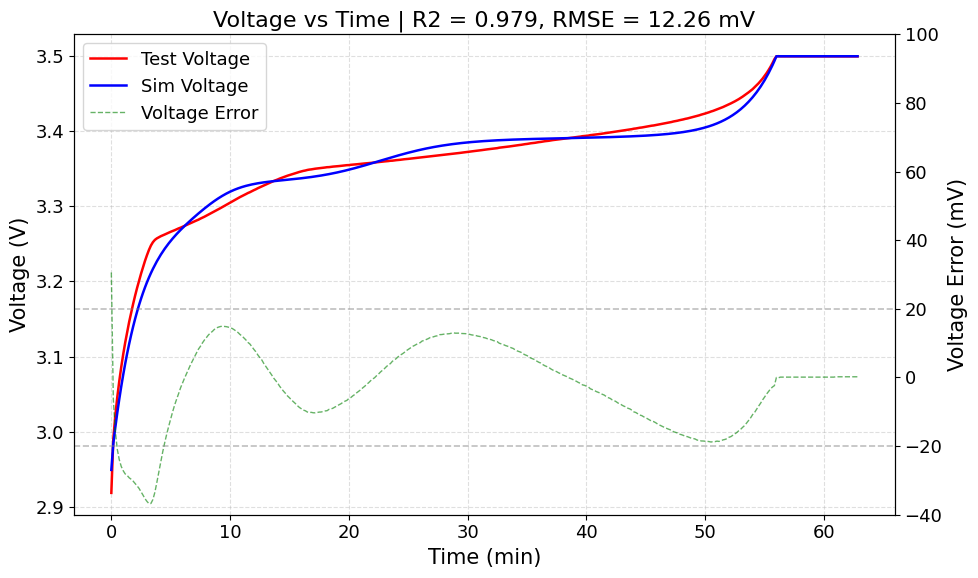

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# =======================
# Test data
# =======================
df = get_test_data("beginning_of_life", "Charge")
test_voltage = df["951 Voltage [V]"].values
test_time = df["951 Time [min]"].values

# =======================
# PyBaMM Simulation
# =======================
exp = pybamm.Experiment(
    [
        (
            "Discharge at 2.5A until 2.5V (1 seconds period)",
            "Rest for 30 minutes (1800 seconds period)",
            "Charge at 2.5A until 3.5V (1 seconds period)",
            "Hold at 3.5V until 0.05A (1 seconds period)"
        )
    ]
)

solver = pybamm.IDAKLUSolver()
sim = pybamm.Simulation(
    model=model,
    parameter_values=params,
    experiment=exp,
    solver=solver,
)

# sol = sim.solve(initial_soc=1.0)
sol = sim.solve(calc_esoh=False)
# sim_time = (
#     sol.cycles[0].steps[2]["Time [min]"].entries
#     - sol.cycles[0].steps[2]["Time [min]"].entries[0]
# )

# sim_voltage = sol.cycles[0].steps[2]["Terminal voltage [V]"].entries

sim_time_cc = sol.cycles[0].steps[2]["Time [min]"].entries - sol.cycles[0].steps[2]["Time [min]"].entries[0]
sim_time_cv = sol.cycles[0].steps[3]["Time [min]"].entries - sol.cycles[0].steps[3]["Time [min]"].entries[0] + sim_time_cc[-1]

sim_time = np.concatenate(
    (sim_time_cc, sim_time_cv)
)

# sim_time = (
#     sol.cycles[0].steps[2]["Time [min]"].entries
#     - sol.cycles[0].steps[2]["Time [min]"].entries[0]
# )

sim_voltage_cc = sol.cycles[0].steps[2]["Terminal voltage [V]"].entries
sim_voltage_cv = sol.cycles[0].steps[3]["Terminal voltage [V]"].entries

sim_voltage = np.concatenate(
    (sim_voltage_cc, sim_voltage_cv)
)



# =======================
# Remove NaNs from test data
# =======================
mask_test = np.isfinite(test_time) & np.isfinite(test_voltage)
test_time = test_time[mask_test]
test_voltage = test_voltage[mask_test]

# =======================
# Restrict to common capacity range
# =======================
time_min = max(test_time.min(), sim_time.min())
time_max = min(test_time.max(), sim_time.max())

mask_common = (test_time >= time_min) & (test_time <= time_max)

test_time = test_time[mask_common]
test_voltage = test_voltage[mask_common]

# =======================
# Interpolate simulation voltage
# =======================
sim_voltage_interp = np.interp(
    test_time,
    sim_time,
    sim_voltage
)

# =======================
# Final NaN guard
# =======================
mask_final = np.isfinite(sim_voltage_interp) & np.isfinite(test_voltage)

capacity_f = test_time[mask_final]
test_voltage_f = test_voltage[mask_final]
sim_voltage_f = sim_voltage_interp[mask_final]

# =======================
# Error metrics
# =======================
voltage_error = (sim_voltage_f - test_voltage_f)*1000   ## mV

rmse = np.sqrt(mean_squared_error(test_voltage_f, sim_voltage_f))
r2 = r2_score(test_voltage_f, sim_voltage_f)

# =======================
# Plot
# =======================
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(capacity_f, test_voltage_f, 'r', lw=1.8, label="Test Voltage")
ax1.plot(capacity_f, sim_voltage_f, 'b', lw=1.8, label="Sim Voltage")

ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Voltage (V)")
ax1.grid(True, ls="--", alpha=0.4)

ax2 = ax1.twinx()
ax2.plot(capacity_f, voltage_error, 'g--', lw=1, label="Voltage Error", alpha=0.6)

# >>> ADD THESE TWO LINES <<<
ax2.axhline(20, color="gray", linestyle="--", linewidth=1.2, alpha=0.5)
ax2.axhline(-20, color="gray", linestyle="--", linewidth=1.2, alpha=0.5)


ax2.set_ylabel("Voltage Error (mV)")
ax2.set_ylim(-40, 100)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

ax1.set_title(
    f"Voltage vs Time | R2 = {r2:.3f}, RMSE = {rmse*1000:.2f} mV"
)

plt.tight_layout()
plt.show()


2025-12-23 17:46:48.068 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 17:46:48.069 - [NOTICE] logger.func(7): Cycle 1/1, step 1/1: Discharge at C/2 for 10 hours or until 2.5V (1 seconds period)
2025-12-23 17:46:48.115 - [NOTICE] logger.func(7): Finish experiment simulation, took 46.924 ms
2025-12-23 17:46:48.175 - [NOTICE] logger.func(7): Cycle 1/1 (12.600 us elapsed) --------------------
2025-12-23 17:46:48.176 - [NOTICE] logger.func(7): Cycle 1/1, step 1/1: Discharge at 1C for 10 hours or until 2.5V (1 seconds period)
2025-12-23 17:46:48.220 - [NOTICE] logger.func(7): Finish experiment simulation, took 44.215 ms
2025-12-23 17:46:48.274 - [NOTICE] logger.func(7): Cycle 1/1 (10.300 us elapsed) --------------------
2025-12-23 17:46:48.274 - [NOTICE] logger.func(7): Cycle 1/1, step 1/1: Discharge at 2C for 10 hours or until 2.5V (1 seconds period)


Discharge Capacity at C/2 : 2.4525936066275023
N/P ratio at C/2 : 1.18503453038674
Discharge Capacity at 1C : 2.444986415103455
N/P ratio at 1C : 1.18503453038674


2025-12-23 17:46:48.317 - [NOTICE] logger.func(7): Finish experiment simulation, took 43.232 ms
2025-12-23 17:46:48.375 - [NOTICE] logger.func(7): Cycle 1/1 (10.300 us elapsed) --------------------
2025-12-23 17:46:48.376 - [NOTICE] logger.func(7): Cycle 1/1, step 1/1: Discharge at 3C for 10 hours or until 2.5V (1 seconds period)
2025-12-23 17:46:48.415 - [NOTICE] logger.func(7): Finish experiment simulation, took 40.207 ms


Discharge Capacity at 2C : 2.4346581042570343
N/P ratio at 2C : 1.18503453038674
Discharge Capacity at 3C : 2.4266613355485793
N/P ratio at 3C : 1.18503453038674


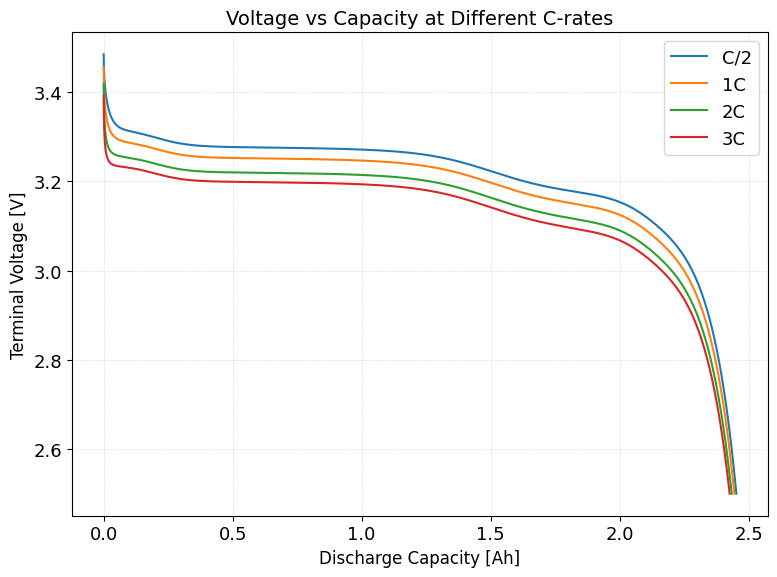

In [40]:
# ================= USER DEFINITIONS =================
C_rates = {
    "C/2": "C/2",
    "1C": "1C",
    "2C": "2C",
    "3C": "3C",
}


model.variables["Anode potential [V]"] = model.variables[
    "Negative electrode surface potential difference at separator interface [V]"
]



solver = pybamm.IDAKLUSolver()

plt.figure(figsize=(8, 6))

# ================= LOOP OVER C-RATES =================
for label, C in C_rates.items():

    exp = pybamm.Experiment(
        [
            f"Discharge at {C} for 10 hours or until 2.5V (1 seconds period)",
        ]
    )

    sim = pybamm.Simulation(
        model=model,
        parameter_values=params,
        experiment=exp,
        solver=solver,
    )

    sol = sim.solve(calc_esoh=False)

    # ---- Capacity (Ah) ----
    cap = sol["Discharge capacity [A.h]"].entries
    cap = cap - cap[0]   # normalize to zero start
    
    print("Discharge Capacity at", label, ":", cap[-1])

    # ---- Voltage (V) ----
    voltage = sol["Terminal voltage [V]"].entries
    
    NE_cap = sol["Negative electrode capacity [A.h]"].entries[-1]
    PE_cap = sol["Positive electrode capacity [A.h]"].entries[-1]
    
    print("N/P ratio at", label, ":", NE_cap/PE_cap)

    # ---- Plot ----
    plt.plot(cap, voltage, label=label)

# ================= PLOT FORMATTING =================
plt.xlabel("Discharge Capacity [Ah]", fontsize=12)
plt.ylabel("Terminal Voltage [V]", fontsize=12)
plt.title("Voltage vs Capacity at Different C-rates", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


2025-12-23 17:47:16.203 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 17:47:16.204 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at C/2 for 10 hours or until 2.5V (1 second period)
2025-12-23 17:47:16.248 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (60 seconds period)
2025-12-23 17:47:16.261 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at C/2 until 3.5V (1 second period)
2025-12-23 17:47:16.299 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.01A (1 second period)
2025-12-23 17:47:16.396 - [NOTICE] logger.func(7): Finish experiment simulation, took 192.656 ms
2025-12-23 17:47:16.570 - [NOTICE] logger.func(7): Cycle 1/1 (11.500 us elapsed) --------------------
2025-12-23 17:47:16.571 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 1C for 10 hours or until 2.5V (1 second period)
2025-12-23 17:47:16.611 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minute

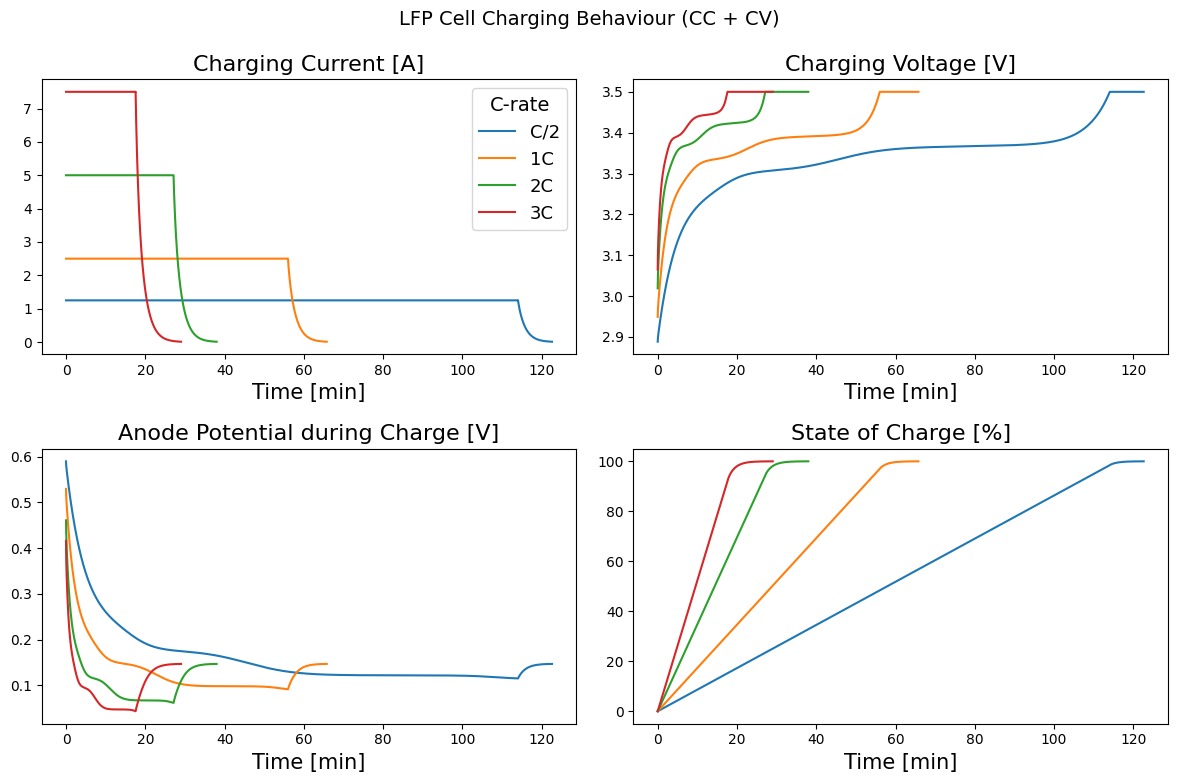

In [41]:
# =========================
# C-rate definitions
# =========================
C_rates = {
    "C/2": "C/2",
    "1C": "1C",
    "2C": "2C",
    "3C": "3C",
}

# =========================
# Alias anode potential
# =========================
model.variables["Anode potential [V]"] = model.variables[
    "Negative electrode surface potential difference at separator interface [V]"
]

# =========================
# Solver
# =========================
solver = pybamm.IDAKLUSolver()

# =========================
# Storage
# =========================
results = {}

# =========================
# Run simulations
# =========================
for label, C in C_rates.items():

    exp = pybamm.Experiment(
        [
            (f"Discharge at {C} for 10 hours or until 2.5V (1 second period)",
            "Rest for 30 minutes (60 seconds period)",
            f"Charge at {C} until 3.5V (1 second period)",
            "Hold at 3.5V until 0.01A (1 second period)",)
        ]
    )

    sim = pybamm.Simulation(
        model=model,
        parameter_values=params,
        experiment=exp,
        solver=solver,
    )

    sol = sim.solve(calc_esoh=False)

    # =========================
    # Extract CHARGING steps only
    # =========================
    charge_cycles = sol.cycles[0]   # single cycle experiment
    charge_step_CC = charge_cycles.steps[2]  # Charge at C
    charge_step_CV = charge_cycles.steps[3]  # Hold at 3.5V

    # Concatenate CC + CV
    t = np.concatenate([
        charge_step_CC["Time [min]"].entries,
        charge_step_CV["Time [min]"].entries
    ])
    t = t - t[0]

    I = np.abs(np.concatenate([
        charge_step_CC["Current [A]"].entries,
        charge_step_CV["Current [A]"].entries
    ]))

    V = np.concatenate([
        charge_step_CC["Terminal voltage [V]"].entries,
        charge_step_CV["Terminal voltage [V]"].entries
    ])

    anode_V = np.concatenate([
        charge_step_CC["Anode potential [V]"].entries,
        charge_step_CV["Anode potential [V]"].entries
    ])

    cap = np.abs(np.concatenate([
        charge_step_CC["Discharge capacity [A.h]"].entries,
        charge_step_CV["Discharge capacity [A.h]"].entries
    ]) - charge_step_CC["Discharge capacity [A.h]"].entries[0])

    SOC = 100 * cap / cap[-1]

    results[label] = {
        "t": t,
        "I": I,
        "V": V,
        "anode_V": anode_V,
        "SOC": SOC,
    }

# =========================
# Plotting (CHARGE ONLY)
# =========================
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for label, d in results.items():
    axes[0, 0].plot(d["t"], d["I"], label=label)
    axes[0, 1].plot(d["t"], d["V"])
    axes[1, 0].plot(d["t"], d["anode_V"])
    axes[1, 1].plot(d["t"], d["SOC"])


# Titles
axes[0, 0].set_title("Charging Current [A]")
axes[0, 1].set_title("Charging Voltage [V]")
axes[1, 0].set_title("Anode Potential during Charge [V]")
axes[1, 1].set_title("State of Charge [%]")

# Formatting
for ax in axes.flat:
    ax.set_xlabel("Time [min]")
    ax.set_facecolor("white")
    ax.tick_params(axis="both", labelsize=10)
    ax.grid(False)

axes[0, 0].legend(title="C-rate")

plt.suptitle("LFP Cell Charging Behaviour (CC + CV)", fontsize=14)
plt.tight_layout()
plt.show()


### HPPC Charging Protocol (Test data 951 HPPC)

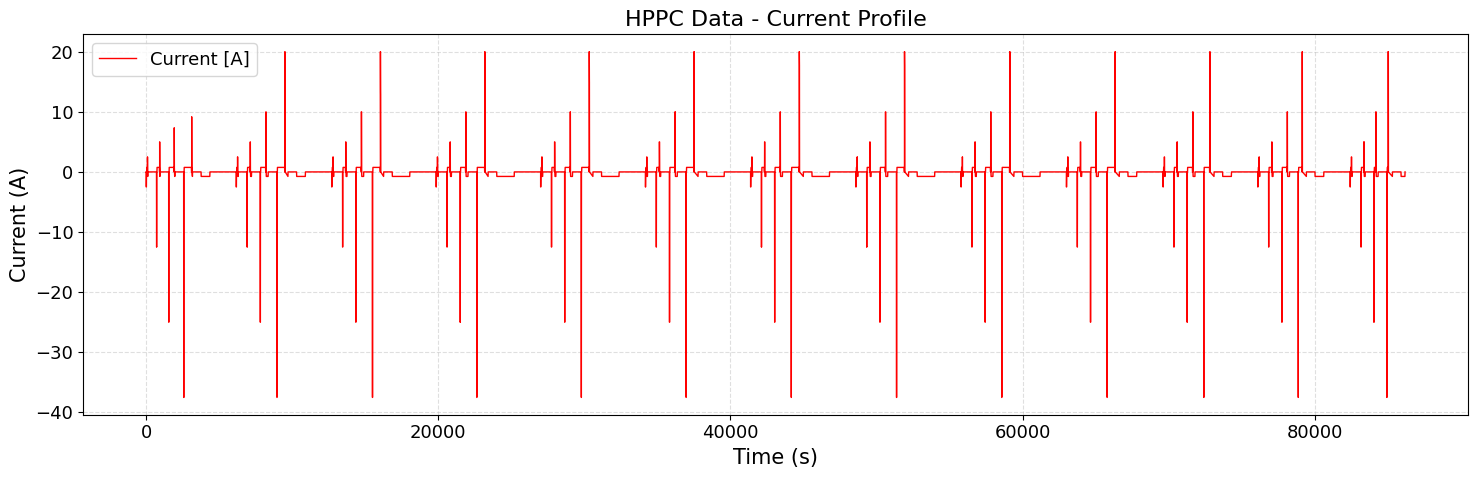

In [26]:
df_HPPC = get_test_data("beginning_of_life", "HPPC 951")
# print(df.head())

plt.figure(figsize=(15, 5))

plt.plot(
    df_HPPC["Time [s]"],
    df_HPPC["Current [A]"],
    color="red",
    linewidth=1,
    label="Current [A]"
)

plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("HPPC Data - Current Profile")

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

### Retracted Protocol for Pybamm Simulation

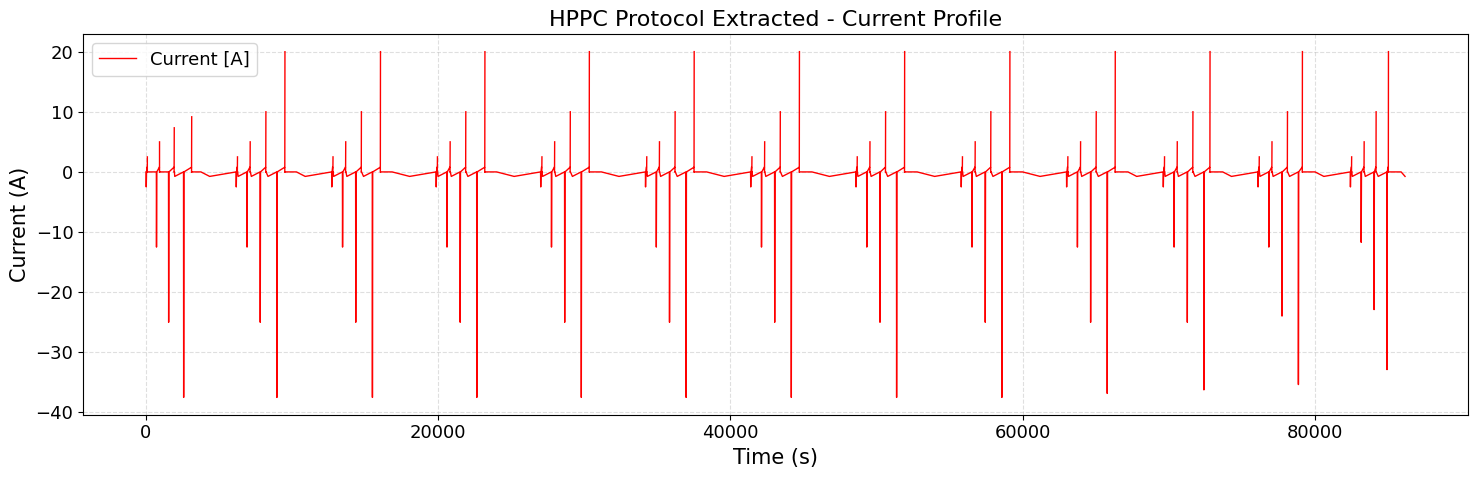

In [27]:
df_HPPC_Protocol = get_test_data("beginning_of_life", "HPPC Protocol")
# print(df.head())

plt.figure(figsize=(15, 5))

plt.plot(
    df_HPPC_Protocol["End_Time_s"],
    df_HPPC_Protocol["Mean_Current_A"],
    color="red",
    linewidth=1,
    label="Current [A]"
)

plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("HPPC Protocol Extracted - Current Profile")

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

Rest for 9.903 seconds (1 seconds period)
Discharge at 2.497200 A for 9.896 seconds or until 2.5V (0.1 seconds period)
Rest for 19.895 seconds (1 seconds period)
Charge at 0.751200 A for 23.691 seconds or until 3.5V (0.1 seconds period)
Hold at 3.5V until 0.05A (0.1 seconds period)
Rest for 19.917 seconds (1 seconds period)
Charge at 2.497300 A for 1.756 seconds or until 3.5V (0.1 seconds period)
Hold at 3.5V until 0.05A (0.1 seconds period)
Rest for 9.907 seconds (1 seconds period)
Rest for 599.031 seconds (1 seconds period)

Total experiment steps: 531


2025-12-23 18:21:51.859 - [NOTICE] logger.func(7): Cycle 1/531 (11.800 us elapsed) --------------------
2025-12-23 18:21:51.860 - [NOTICE] logger.func(7): Cycle 1/531, step 1/1: Rest for 9.903 seconds (1 seconds period)
2025-12-23 18:21:51.879 - [NOTICE] logger.func(7): Cycle 2/531 (18.975 ms elapsed) --------------------
2025-12-23 18:21:51.879 - [NOTICE] logger.func(7): Cycle 2/531, step 1/1: Discharge at 2.497200 A for 9.896 seconds or until 2.5V (0.1 seconds period)
2025-12-23 18:21:51.904 - [NOTICE] logger.func(7): Cycle 3/531 (44.850 ms elapsed) --------------------
2025-12-23 18:21:51.905 - [NOTICE] logger.func(7): Cycle 3/531, step 1/1: Rest for 19.895 seconds (1 seconds period)
2025-12-23 18:21:51.907 - [NOTICE] logger.func(7): Cycle 4/531 (47.512 ms elapsed) --------------------
2025-12-23 18:21:51.907 - [NOTICE] logger.func(7): Cycle 4/531, step 1/1: Charge at 0.751200 A for 23.691 seconds or until 3.5V (0.1 seconds period)
2025-12-23 18:21:51.932 - [WARNING] simulation.solv

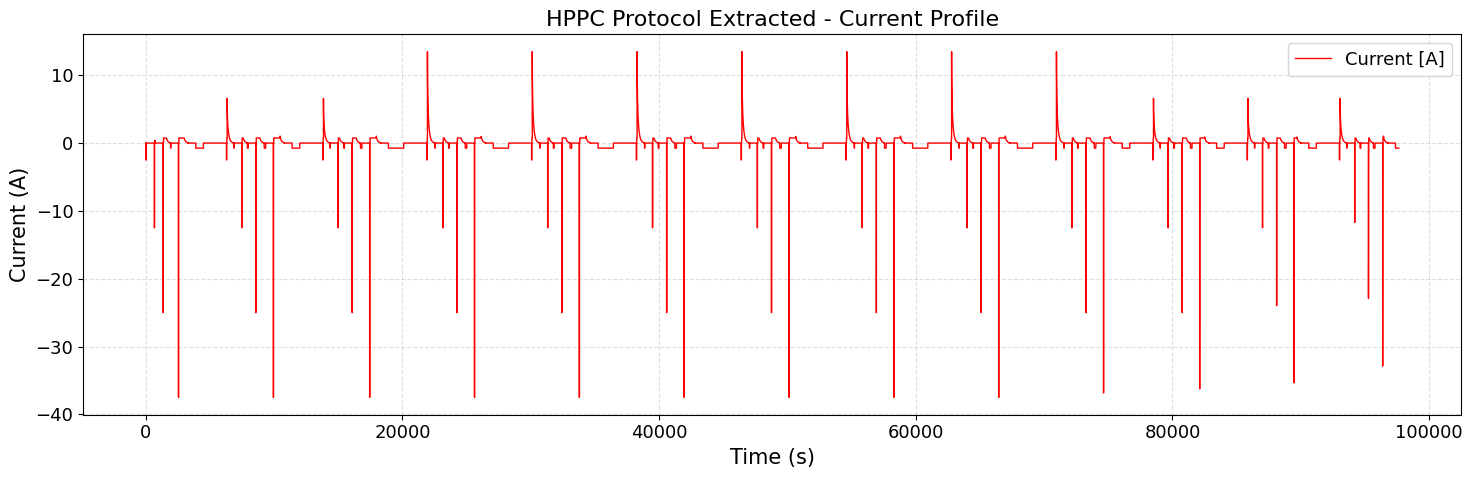

In [43]:
experiment_steps = []

for _, row in df_HPPC_Protocol.iterrows():
    step_type = row["Step_Type"]
    duration = row["Step_Time_s"]
    current = row["Mean_Current_A"]

    # ---- Skip zero-duration steps ----
    if duration <= 0:
        continue

    duration_str = f"{duration:.3f} seconds"

    if step_type == "Rest":
        experiment_steps.append(
            f"Rest for {duration_str} (1 seconds period)"
        )

    elif step_type == "Charge":
        experiment_steps.append(
            f"Charge at {abs(current):.6f} A for {duration_str} or until 3.5V (0.1 seconds period)"
        )
    
    elif step_type == "Hold":
        experiment_steps.append(
            f"Hold at 3.5V until 0.05A (0.1 seconds period)"
        )
        

    elif step_type == "Discharge":
        experiment_steps.append(
            f"Discharge at {abs(current):.6f} A for {duration_str} or until 2.5V (0.1 seconds period)"
        )

    else:
        raise ValueError(f"Unknown Step_Type: {step_type}")

# ----------------------------------------
# Create PyBaMM Experiment
# ----------------------------------------
exp = pybamm.Experiment(experiment_steps)

# ----------------------------------------
# Print for verification
# ----------------------------------------
for s in experiment_steps[:10]:
    print(s)

print(f"\nTotal experiment steps: {len(experiment_steps)}")



solver = pybamm.IDAKLUSolver()
HPPC_sim = pybamm.Simulation(
    model=model,
    parameter_values=params,
    experiment=exp,
    solver=solver
)
HPPC_sol = HPPC_sim.solve(calc_esoh=False)
# HPPC_sol = HPPC_sim.solve(calc_esoh=False)

plt.figure(figsize=(15, 5))

plt.plot(
    HPPC_sol["Time [s]"].entries,
    -1*HPPC_sol["Current [A]"].entries,
    color="red",
    linewidth=1,
    label="Current [A]"
)

plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.title("HPPC Protocol Extracted - Current Profile")

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


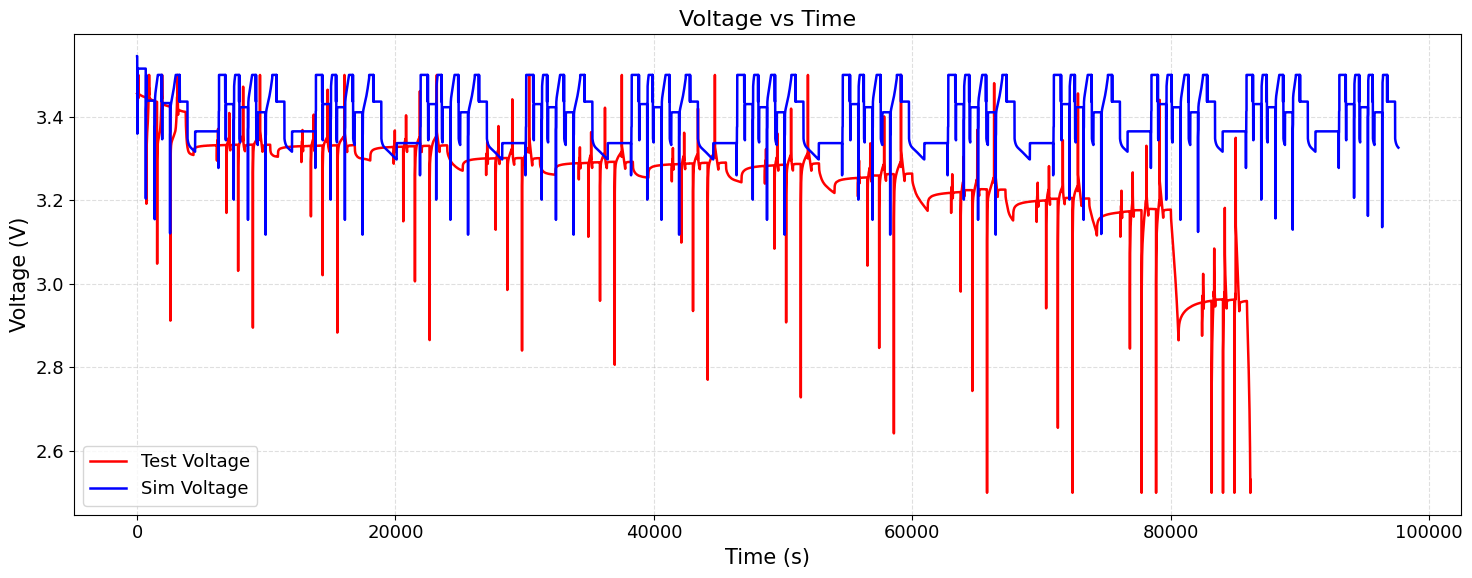

In [47]:
test_time_HPPC = df_HPPC["Time [s]"].values
test_voltage_HPPC = df_HPPC["Voltage [V]"].values
test_current_HPPC = df_HPPC["Current [A]"].values


sim_time_HPPC = HPPC_sol["Time [s]"].entries
sim_voltage_HPPC = HPPC_sol["Terminal voltage [V]"].entries
sim_current_HPPC = HPPC_sol["Current [A]"].entries

# =======================
# Plot
# =======================
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13
})

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(test_time_HPPC, test_voltage_HPPC, 'r', lw=1.8, label="Test Voltage")
ax1.plot(sim_time_HPPC, sim_voltage_HPPC, 'b', lw=1.8, label="Sim Voltage")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (V)")
ax1.grid(True, ls="--", alpha=0.4)
# ax1.set_xlim(0, 50)
# ax2 = ax1.twinx()
# ax2.plot(test_time_f, voltage_error, 'g--', lw=1, label="Voltage Error", alpha=0.6)

# # >>> ADD THESE TWO LINES <<<
# ax2.axhline(20, color="gray", linestyle="--", linewidth=1.2, alpha=0.5)
# ax2.axhline(-20, color="gray", linestyle="--", linewidth=1.2, alpha=0.5)


# ax2.set_ylabel("Voltage Error (mV)")
# ax2.set_ylim(-40, 100)

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1)

ax1.set_title(
    f"Voltage vs Time"
)

plt.tight_layout()
plt.show()


### Parameter Sensitivity Analysis

2025-12-23 18:46:23.668 - [NOTICE] logger.func(7): Cycle 1/1 (18.300 us elapsed) --------------------
2025-12-23 18:46:23.670 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:23.840 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:23.875 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:24.083 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:24.301 - [NOTICE] logger.func(7): Finish experiment simulation, took 636.752 ms
2025-12-23 18:46:24.536 - [NOTICE] logger.func(7): Cycle 1/1 (14.300 us elapsed) --------------------
2025-12-23 18:46:24.537 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:24.622 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

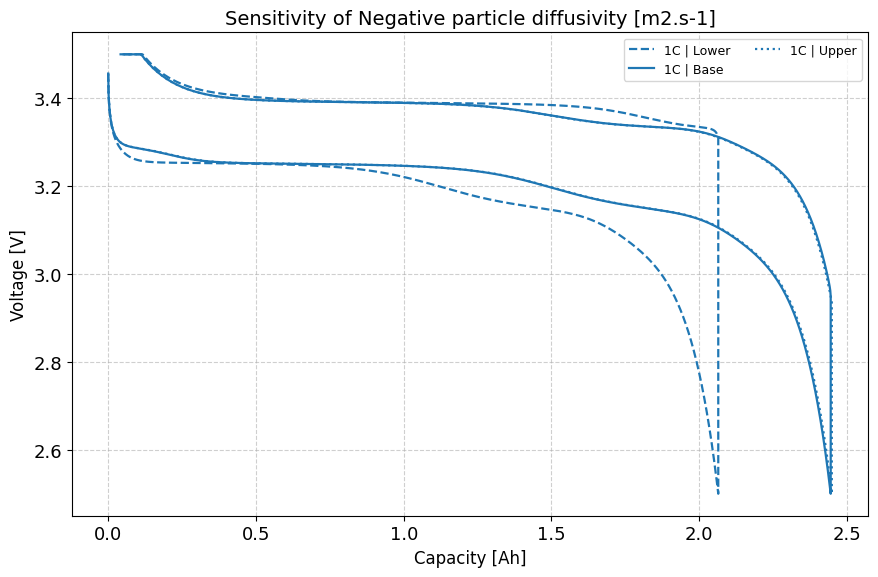

2025-12-23 18:46:25.752 - [NOTICE] logger.func(7): Cycle 1/1 (10.200 us elapsed) --------------------
2025-12-23 18:46:25.752 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:25.855 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:25.876 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:25.979 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:26.119 - [NOTICE] logger.func(7): Finish experiment simulation, took 352.706 ms
2025-12-23 18:46:26.359 - [NOTICE] logger.func(7): Cycle 1/1 (11.300 us elapsed) --------------------
2025-12-23 18:46:26.359 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:26.460 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

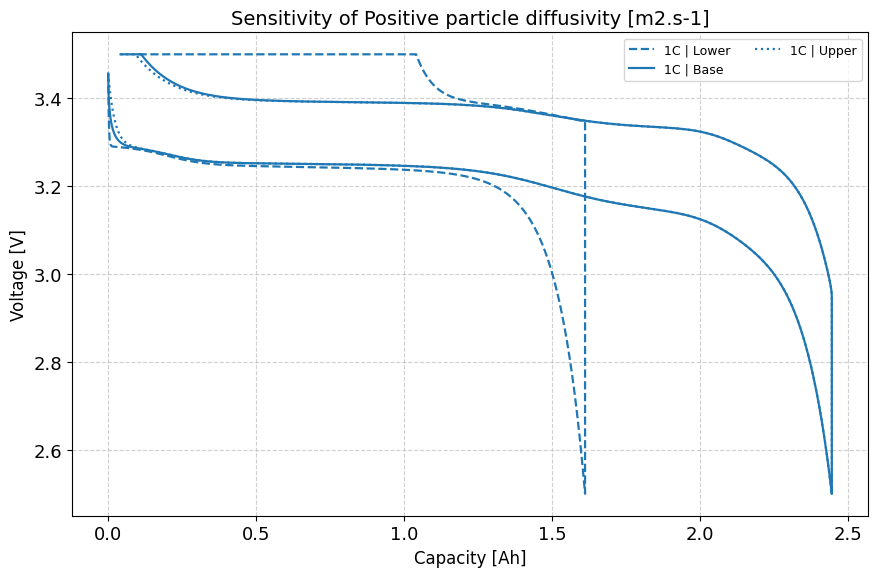

2025-12-23 18:46:27.632 - [NOTICE] logger.func(7): Cycle 1/1 (13.300 us elapsed) --------------------
2025-12-23 18:46:27.633 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:27.727 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:27.749 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:27.823 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:27.951 - [NOTICE] logger.func(7): Finish experiment simulation, took 318.203 ms
2025-12-23 18:46:28.137 - [NOTICE] logger.func(7): Cycle 1/1 (10.100 us elapsed) --------------------
2025-12-23 18:46:28.137 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:28.220 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

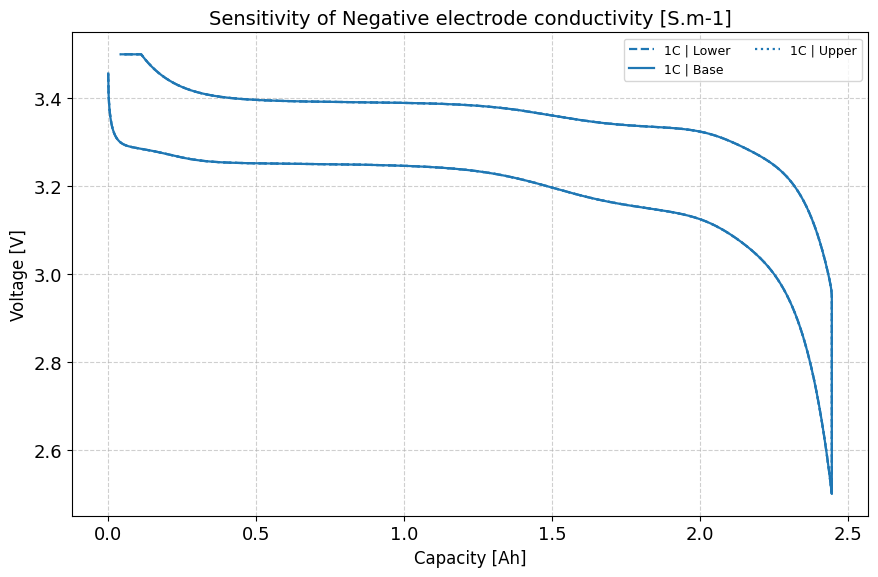

2025-12-23 18:46:29.207 - [NOTICE] logger.func(7): Cycle 1/1 (10.700 us elapsed) --------------------
2025-12-23 18:46:29.210 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:29.300 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:29.319 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:29.384 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:29.486 - [NOTICE] logger.func(7): Finish experiment simulation, took 286.730 ms
2025-12-23 18:46:29.667 - [NOTICE] logger.func(7): Cycle 1/1 (10.000 us elapsed) --------------------
2025-12-23 18:46:29.667 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:29.751 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

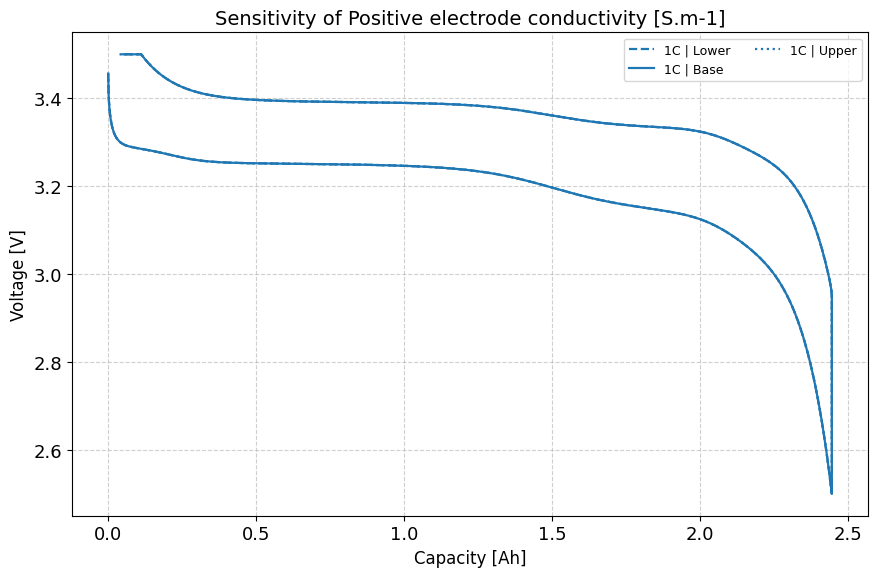

2025-12-23 18:46:31.355 - [NOTICE] logger.func(7): Cycle 1/1 (10.400 us elapsed) --------------------
2025-12-23 18:46:31.356 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:31.439 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:31.459 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:31.533 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:31.622 - [NOTICE] logger.func(7): Finish experiment simulation, took 267.590 ms
2025-12-23 18:46:31.826 - [NOTICE] logger.func(7): Cycle 1/1 (10.000 us elapsed) --------------------
2025-12-23 18:46:31.826 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:31.890 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

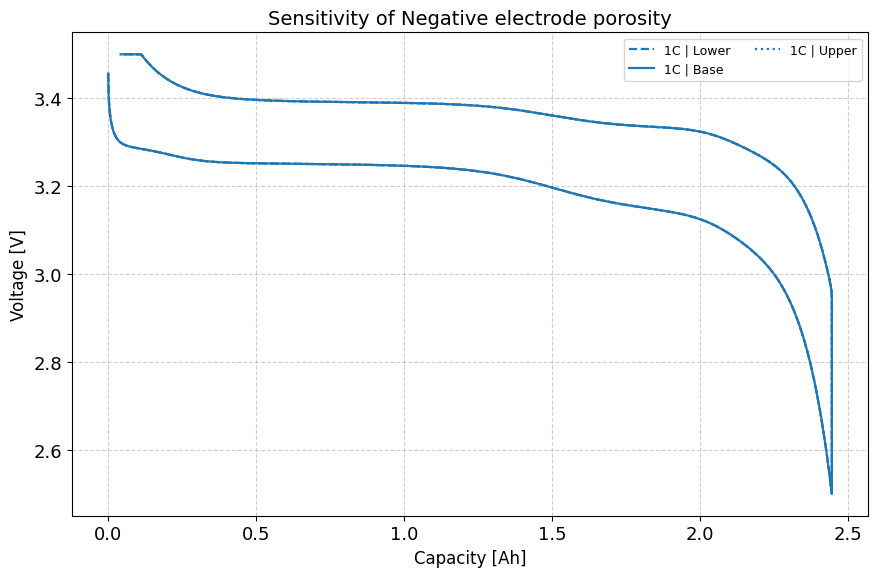

2025-12-23 18:46:32.813 - [NOTICE] logger.func(7): Cycle 1/1 (10.600 us elapsed) --------------------
2025-12-23 18:46:32.813 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:32.913 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:32.923 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:32.999 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:33.086 - [NOTICE] logger.func(7): Finish experiment simulation, took 272.188 ms
2025-12-23 18:46:33.272 - [NOTICE] logger.func(7): Cycle 1/1 (9.600 us elapsed) --------------------
2025-12-23 18:46:33.272 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:33.343 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
202

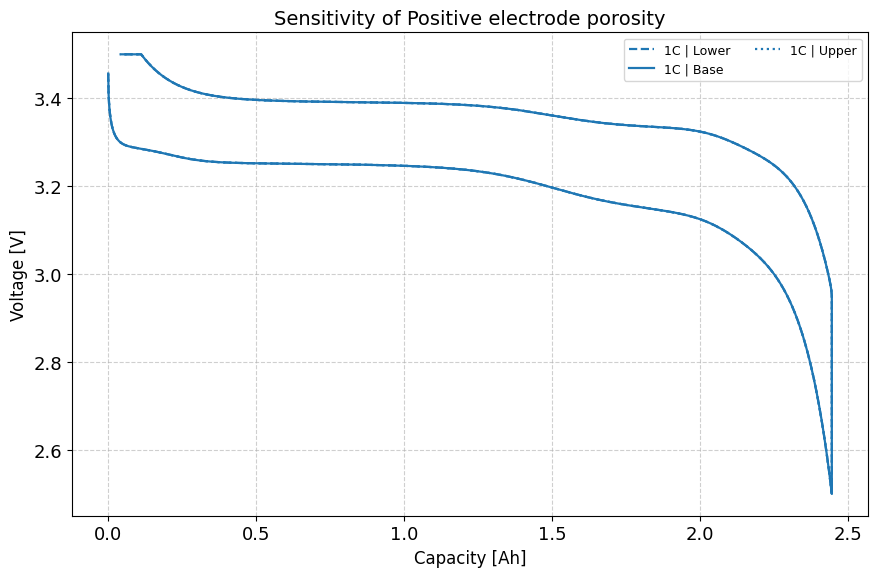

2025-12-23 18:46:34.250 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 18:46:34.250 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:34.334 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:34.356 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:34.434 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:34.530 - [NOTICE] logger.func(7): Finish experiment simulation, took 269.565 ms
2025-12-23 18:46:34.737 - [NOTICE] logger.func(7): Cycle 1/1 (10.600 us elapsed) --------------------
2025-12-23 18:46:34.737 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:34.801 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

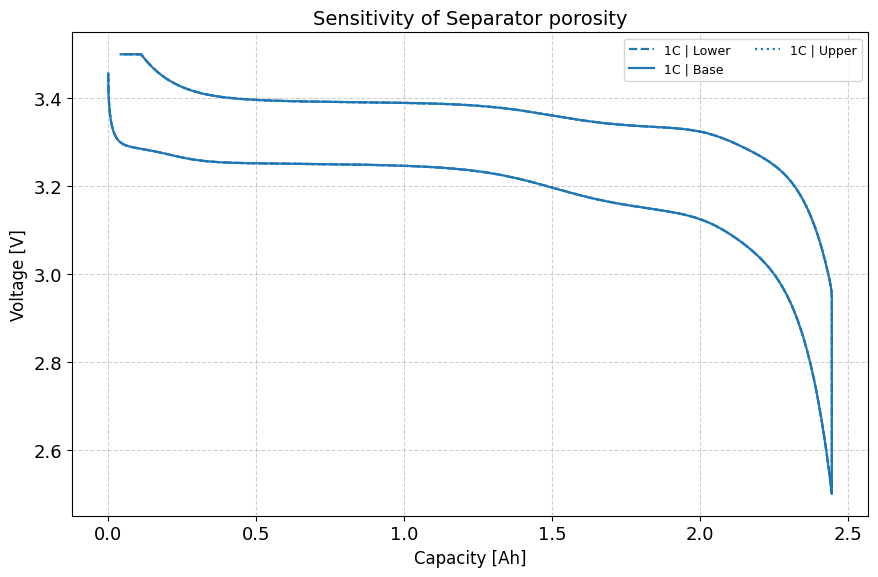

2025-12-23 18:46:35.750 - [NOTICE] logger.func(7): Cycle 1/1 (10.400 us elapsed) --------------------
2025-12-23 18:46:35.750 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:35.838 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:35.857 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:35.933 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:36.026 - [NOTICE] logger.func(7): Finish experiment simulation, took 275.283 ms
2025-12-23 18:46:36.218 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 18:46:36.219 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:36.295 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

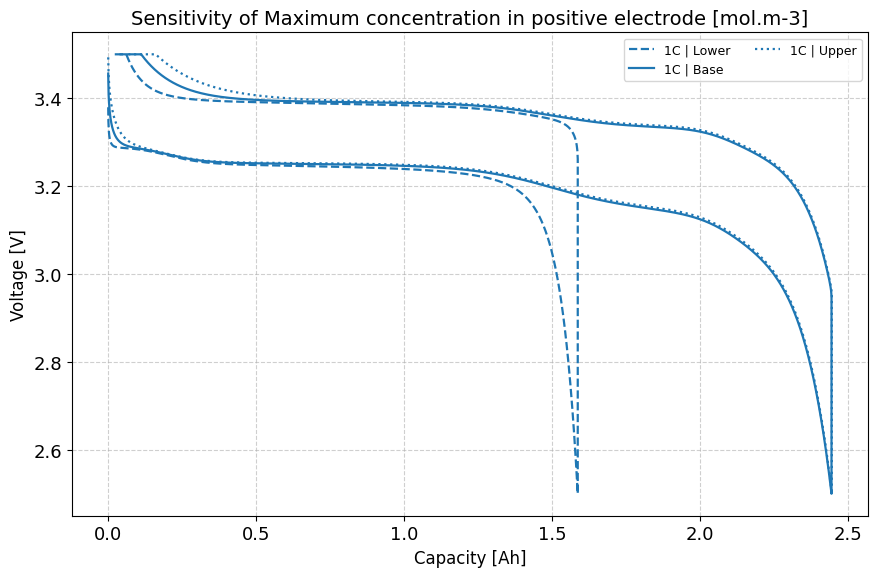

2025-12-23 18:46:37.951 - [NOTICE] logger.func(7): Cycle 1/1 (9.800 us elapsed) --------------------
2025-12-23 18:46:37.951 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:38.027 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:38.034 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:38.110 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:38.185 - [NOTICE] logger.func(7): Finish experiment simulation, took 227.490 ms
2025-12-23 18:46:38.368 - [NOTICE] logger.func(7): Cycle 1/1 (10.400 us elapsed) --------------------
2025-12-23 18:46:38.368 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:38.448 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
202

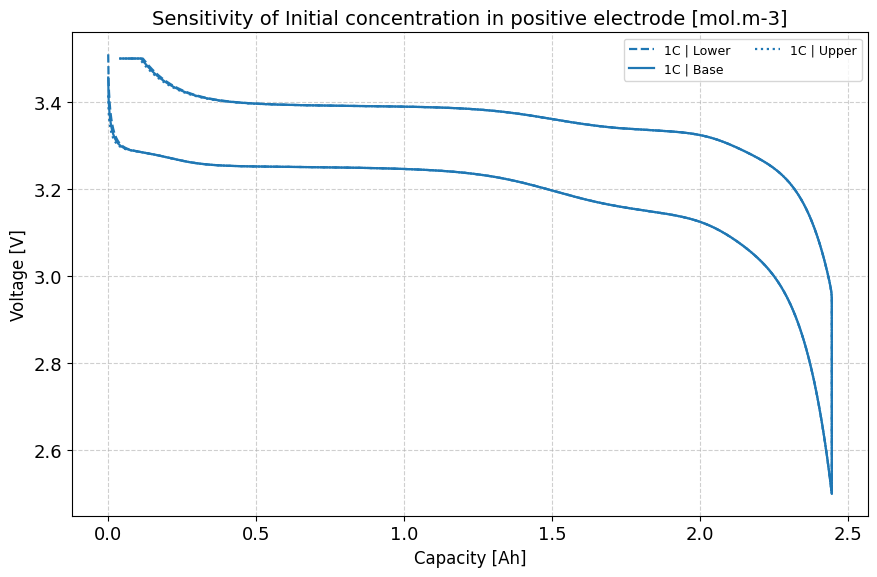

2025-12-23 18:46:39.362 - [NOTICE] logger.func(7): Cycle 1/1 (11.200 us elapsed) --------------------
2025-12-23 18:46:39.362 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:39.385 - [ERROR] callbacks.on_experiment_error(235): Simulation error: Events ['Maximum voltage [V]'] are non-positive at initial conditions
2025-12-23 18:46:39.517 - [NOTICE] logger.func(7): Cycle 1/1 (54.200 us elapsed) --------------------
2025-12-23 18:46:39.518 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)


❌ Simulation failed for Maximum concentration in negative electrode [mol.m-3]: Events ['Maximum voltage [V]'] are non-positive at initial conditions


2025-12-23 18:46:39.589 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:39.601 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:39.667 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:39.772 - [NOTICE] logger.func(7): Finish experiment simulation, took 254.602 ms
2025-12-23 18:46:39.984 - [NOTICE] logger.func(7): Cycle 1/1 (11.900 us elapsed) --------------------
2025-12-23 18:46:39.984 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:40.060 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:40.067 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:40.151 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds

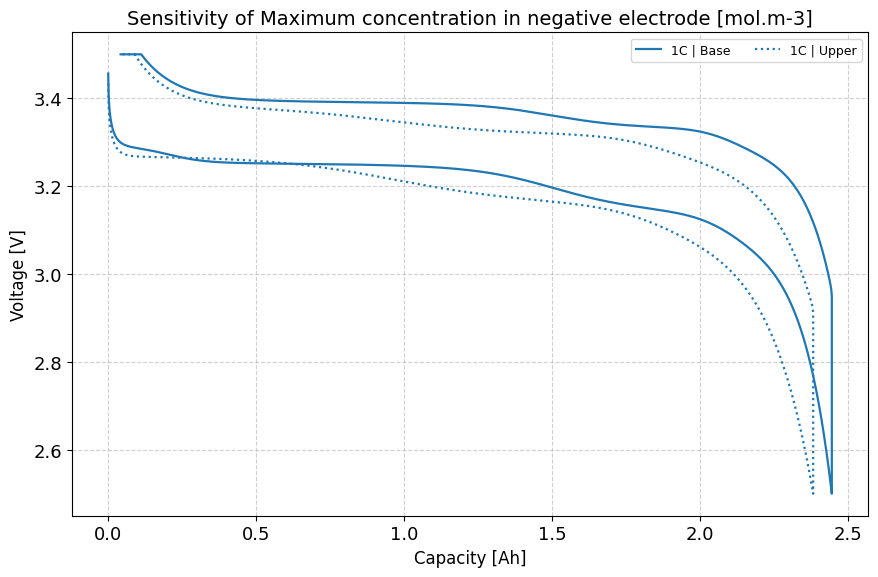

2025-12-23 18:46:40.534 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 18:46:40.534 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:40.620 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:40.651 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:40.726 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:40.823 - [NOTICE] logger.func(7): Finish experiment simulation, took 276.451 ms
2025-12-23 18:46:41.019 - [NOTICE] logger.func(7): Cycle 1/1 (11.700 us elapsed) --------------------
2025-12-23 18:46:41.020 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:41.084 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

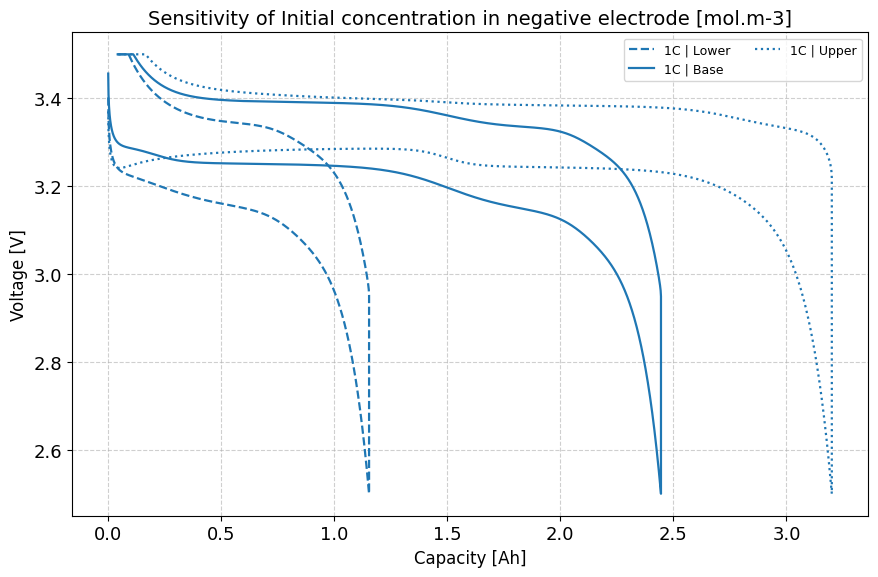

2025-12-23 18:46:42.057 - [NOTICE] logger.func(7): Cycle 1/1 (9.800 us elapsed) --------------------
2025-12-23 18:46:42.057 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:42.144 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:42.169 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:42.239 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:42.372 - [NOTICE] logger.func(7): Finish experiment simulation, took 316.393 ms
2025-12-23 18:46:42.576 - [NOTICE] logger.func(7): Cycle 1/1 (10.700 us elapsed) --------------------
2025-12-23 18:46:42.576 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:42.654 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
202

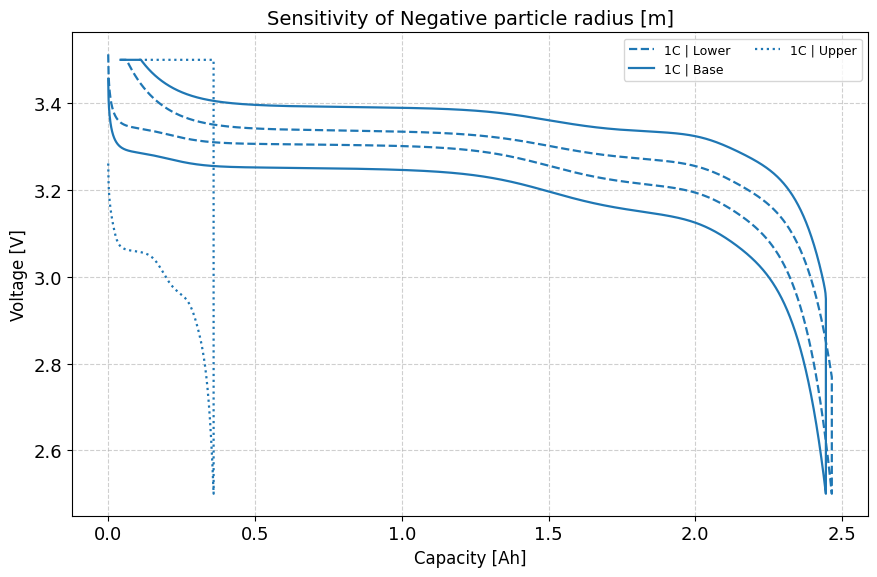

2025-12-23 18:46:44.351 - [NOTICE] logger.func(7): Cycle 1/1 (10.700 us elapsed) --------------------
2025-12-23 18:46:44.351 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:44.472 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:44.489 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:44.559 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:44.651 - [NOTICE] logger.func(7): Finish experiment simulation, took 295.492 ms
2025-12-23 18:46:44.848 - [NOTICE] logger.func(7): Cycle 1/1 (10.600 us elapsed) --------------------
2025-12-23 18:46:44.849 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:44.922 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

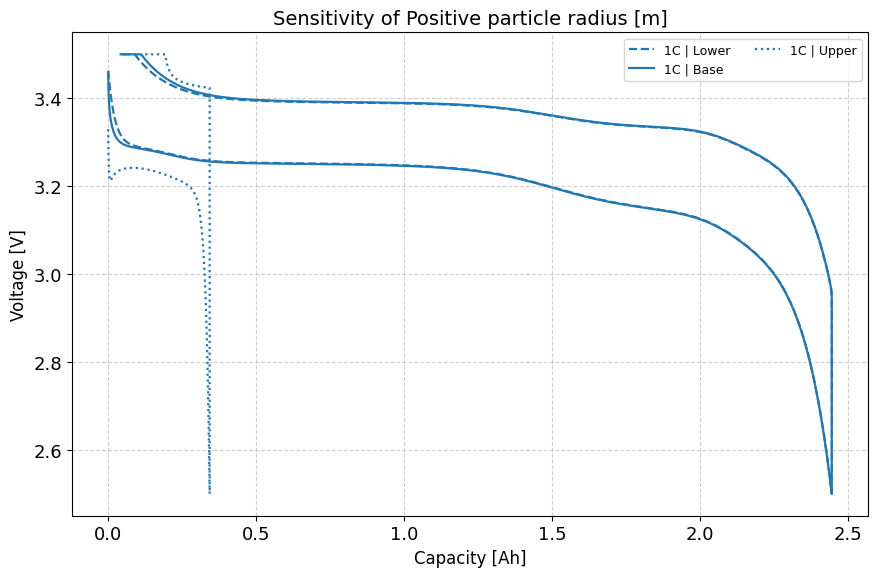

2025-12-23 18:46:45.863 - [NOTICE] logger.func(7): Cycle 1/1 (11.200 us elapsed) --------------------
2025-12-23 18:46:45.864 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:45.940 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:45.958 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:46.039 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:46.136 - [NOTICE] logger.func(7): Finish experiment simulation, took 272.589 ms
2025-12-23 18:46:46.323 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 18:46:46.325 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:46.404 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

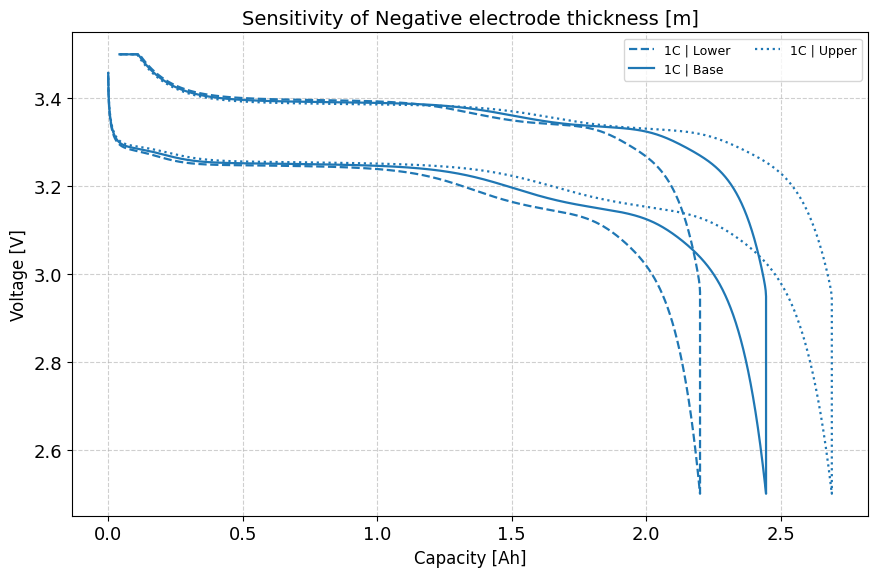

2025-12-23 18:46:47.391 - [NOTICE] logger.func(7): Cycle 1/1 (14.700 us elapsed) --------------------
2025-12-23 18:46:47.392 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:47.480 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:47.498 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:47.579 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:47.685 - [NOTICE] logger.func(7): Finish experiment simulation, took 294.538 ms
2025-12-23 18:46:47.926 - [NOTICE] logger.func(7): Cycle 1/1 (13.000 us elapsed) --------------------
2025-12-23 18:46:47.927 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:48.034 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

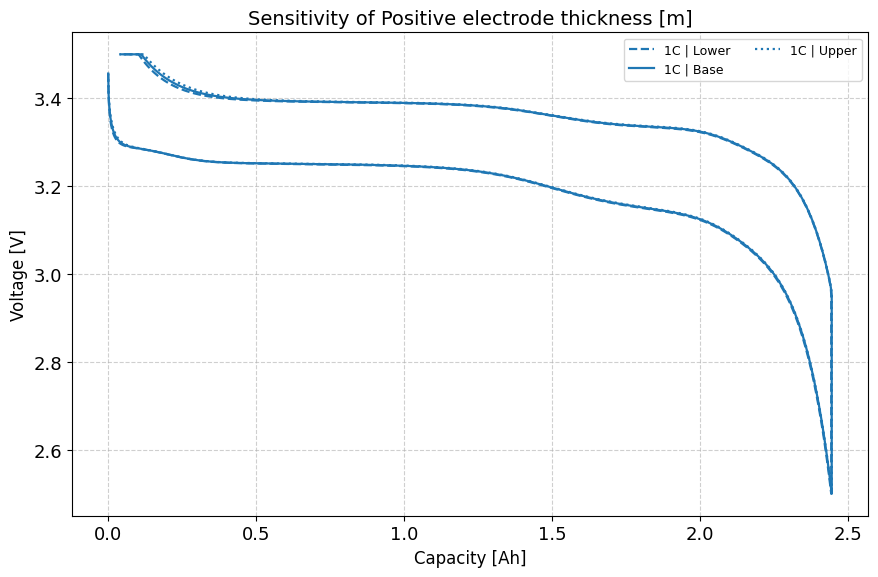

2025-12-23 18:46:49.044 - [NOTICE] logger.func(7): Cycle 1/1 (9.600 us elapsed) --------------------
2025-12-23 18:46:49.045 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:49.129 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:49.146 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:49.221 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:49.320 - [NOTICE] logger.func(7): Finish experiment simulation, took 274.957 ms
2025-12-23 18:46:49.511 - [NOTICE] logger.func(7): Cycle 1/1 (20.900 us elapsed) --------------------
2025-12-23 18:46:49.512 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:49.584 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
202

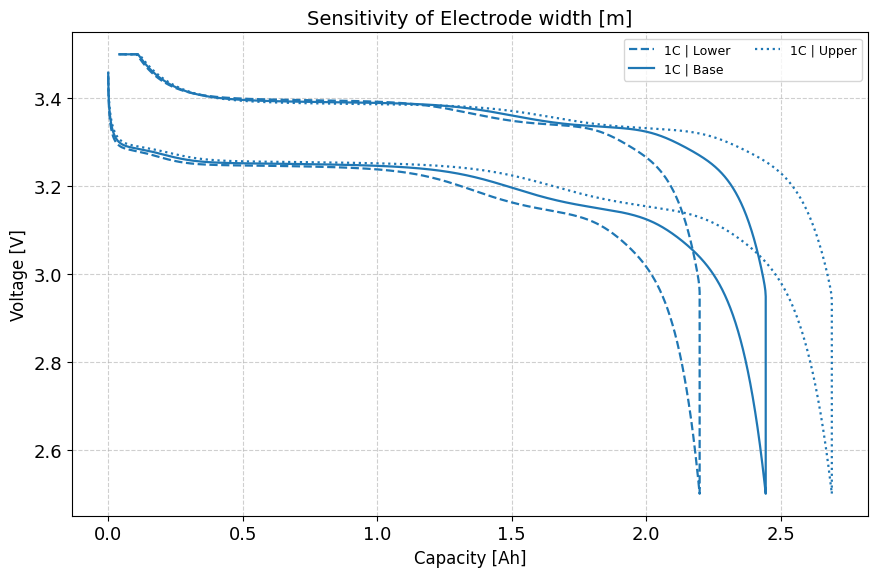

2025-12-23 18:46:51.244 - [NOTICE] logger.func(7): Cycle 1/1 (11.000 us elapsed) --------------------
2025-12-23 18:46:51.245 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:51.328 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:51.348 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:51.426 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:51.509 - [NOTICE] logger.func(7): Finish experiment simulation, took 265.732 ms
2025-12-23 18:46:51.710 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 18:46:51.712 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:51.785 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

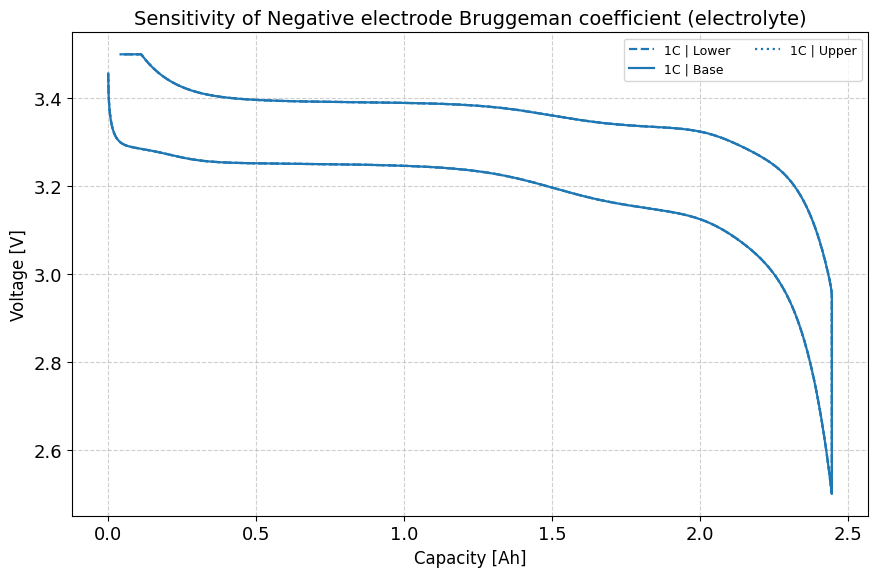

2025-12-23 18:46:52.708 - [NOTICE] logger.func(7): Cycle 1/1 (10.400 us elapsed) --------------------
2025-12-23 18:46:52.719 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:52.786 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:52.806 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:52.915 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:52.999 - [NOTICE] logger.func(7): Finish experiment simulation, took 284.094 ms
2025-12-23 18:46:53.201 - [NOTICE] logger.func(7): Cycle 1/1 (10.100 us elapsed) --------------------
2025-12-23 18:46:53.201 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:53.285 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

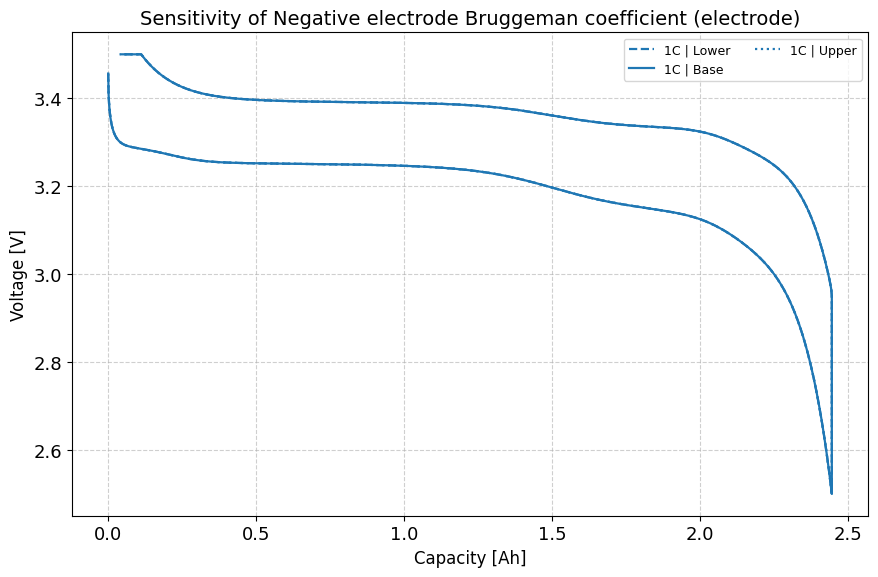

2025-12-23 18:46:54.287 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 18:46:54.287 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:54.369 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:54.389 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:54.467 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:54.563 - [NOTICE] logger.func(7): Finish experiment simulation, took 272.183 ms
2025-12-23 18:46:54.755 - [NOTICE] logger.func(7): Cycle 1/1 (10.500 us elapsed) --------------------
2025-12-23 18:46:54.755 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:54.833 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

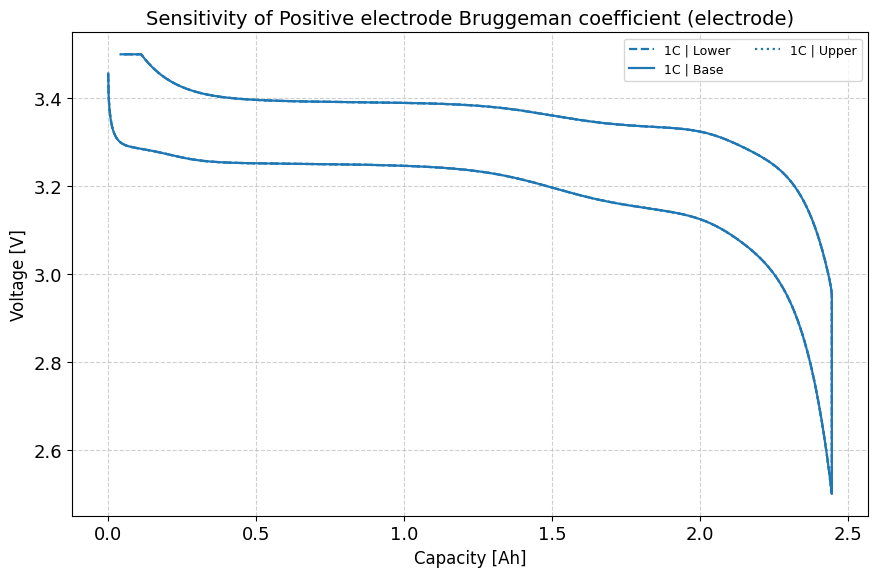

2025-12-23 18:46:55.803 - [NOTICE] logger.func(7): Cycle 1/1 (10.300 us elapsed) --------------------
2025-12-23 18:46:55.804 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:55.908 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
2025-12-23 18:46:55.926 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 2.5A until 3.5V (1 seconds period)
2025-12-23 18:46:56.005 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 3.5V until 0.05A (1 seconds period)
2025-12-23 18:46:56.101 - [NOTICE] logger.func(7): Finish experiment simulation, took 299.037 ms
2025-12-23 18:46:56.319 - [NOTICE] logger.func(7): Cycle 1/1 (12.500 us elapsed) --------------------
2025-12-23 18:46:56.320 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 2.5A until 2.5V (1 seconds period)
2025-12-23 18:46:56.414 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 30 minutes (10 seconds period)
20

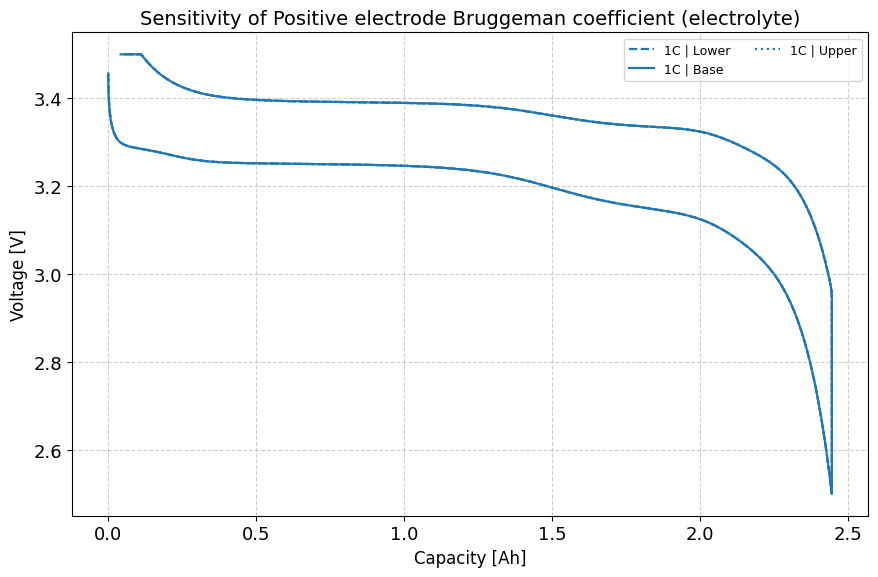

In [50]:
# ============================================================
# PyBaMM Parameter Sensitivity Analysis across 4 C-rates (0.5C, 1C, 2C, 3C)
# ============================================================
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

# ============================================================
# 1. Define Experiments and Crates
# ============================================================
# exp1 = pybamm.Experiment(
#     [
#         (
#             # "Rest for 30 minutes",
#             "Discharge at 0.5A until 2.5 V (1 seconds period)"
#         )
#     ]
# )

# exp2 = pybamm.Experiment(
#     [
#         (
#             # "Rest for 30 minutes",
#             "Discharge at 2.5A until 2.5 V (1 seconds period)"
#         )
#     ]
# )

# exp3 = pybamm.Experiment(
#     [
#         (
#             # "Rest for 30 minutes",
#             "Discharge at 5A until 2.5 V (1 seconds period)"
#         )
#     ]
# )

# exp4 = pybamm.Experiment(
#     [
#         (
#             # "Rest for 30 minutes",
#             "Discharge at 10A until 2.5 V (1 seconds period)"
#         )
#     ]
# )

# experiments = [exp1, exp2, exp3, exp4]
# crates = ["0.2C", "1C", "2C", "4C"]

exp = pybamm.Experiment(
    [
        (
            "Discharge at 2.5A until 2.5V (1 seconds period)",
            "Rest for 30 minutes (10 seconds period)",
            "Charge at 2.5A until 3.5V (1 seconds period)",
            "Hold at 3.5V until 0.05A (1 seconds period)"
        )
    ]
)

experiments = [exp]
crates = ["1C"]



# ============================================================
# # 2. Load Experimental Test Data
# # ============================================================
# try:
#     df = get_test_data(test_datasheet_names[0], "Discharge_constant_amb_25degC")
#     test_data = []
#     for c in ["0.5", "1", "2", "3"]:
#         cap = df[f"{c}C_CE_cap (Ah)"].dropna().values
#         volt = df[f"{c}C_CE Voltage (V)"].dropna().values
#         test_data.append((cap, volt))
#     print("✅ Experimental data loaded successfully.")
# except Exception as e:
#     print(f"⚠️ Could not load experimental data: {e}")
#     test_data = [None, None, None]

# except Exception as e:
#     print(f"⚠️ Could not load experimental data: {e}")
#     test_data = [None, None, None, None]



# ##### Need to optimize
a = "Negative particle diffusivity [m2.s-1]"
b = "Positive particle diffusivity [m2.s-1]"
c = "Negative electrode conductivity [S.m-1]"
d = "Positive electrode conductivity [S.m-1]"
e = "Negative electrode porosity"
f = "Positive electrode porosity"
g = "Separator porosity"
h = "Maximum concentration in positive electrode [mol.m-3]"
i = "Initial concentration in positive electrode [mol.m-3]"
j = "Maximum concentration in negative electrode [mol.m-3]"
k = "Initial concentration in negative electrode [mol.m-3]"
l = "Negative particle radius [m]"
m = "Positive particle radius [m]"
n = "Negative electrode thickness [m]"
o = "Positive electrode thickness [m]"
p = "Electrode width [m]"
q = "Negative electrode Bruggeman coefficient (electrolyte)"
r = "Negative electrode Bruggeman coefficient (electrode)"
s = "Positive electrode Bruggeman coefficient (electrode)"
t = "Positive electrode Bruggeman coefficient (electrolyte)"
u = "Total heat transfer coefficient [W.m-2.K-1]"



# === Step 3: Define parameter bounds ===
bounds = {
    a: [0.01 * params[a], 100*params[a]],
    b: [0.01 * params[b], 100*params[b]],
    c: [0.5*params[c], 5*params[c]],
    d: [0.5*params[d], 5*params[d]],
    e: [0.25, 0.4],
    f: [0.3, 0.46],
    g: [0.4, 0.5],
    h: [0.5*params[h], 1.5*params[h]],
    i: [0.5*(params[i]), 1.5*(params[i])],
    j: [0.5*params[j], 1.5*params[j]],
    k: [0.5*params[k], 1.5*params[k]],
    l: [0.01*params[l], 50*params[l]],
    m: [0.01*params[m], 50*params[m]],
    n: [0.9*params[n], 1.10*params[n]],
    o: [0.9*params[o], 1.10*params[o]],
    p: [0.9*params[p], 1.10*params[p]],
    q: [0.25*params[q], 3*params[q]],
    r: [0.25*params[r], 3*params[r]],
    s: [0.25*params[s], 3*params[s]],
    t: [0.25*params[t], 3*params[t]],
    # u: [0.5*params[u], 10*params[u]],
}

# ============================================================
# 4. Helper Function: Run Simulation
# ============================================================
def run_simulation(exp, param_dict):
    try:
        local_params = deepcopy(params)
        local_params.update(param_dict)
        sim = pybamm.Simulation(model, parameter_values=local_params, experiment=exp, solver=solver)
        sol = sim.solve(calc_esoh=False)
        cap = sol["Discharge capacity [A.h]"].entries - sol["Discharge capacity [A.h]"].entries[0]
        volt = sol["Terminal voltage [V]"].entries
        return cap, volt
    except Exception as e:
        print(f"❌ Simulation failed for {list(param_dict.keys())[0]}: {e}")
        return None, None

# # ============================================================
# # 5. Sensitivity Analysis for Each Parameter (4 Experiments)
# # ============================================================
# def sensitivity_analysis_multi_expt(bounds_dict):
#     """
#     Sensitivity analysis for all parameters in bounds_dict.
#     For each parameter:
#       - Run simulations for lower, base, upper values.
#       - Compare with experimental curves at 4 C-rates.
#       - Show results in a 2x2 grid of subplots.
#     """
#     n_exp = len(experiments)
#     assert n_exp == 4, f"Expected 4 experiments, got {n_exp}"
#     # assert len(test_data) == 4, f"Expected 4 test datasets, got {len(test_data)}"

#     for param_name, (low, high) in bounds_dict.items():
#         base = params[param_name]
#         values = [low, base, high]
#         labels = ["Lower Bound", "Base", "Upper Bound"]

#         # Create 2x2 subplot grid for 4 C-rates
#         fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
#         axes = axes.flatten()
#         plt.suptitle(f"Sensitivity of {param_name}", fontsize=15)

#         color_cycle = plt.cm.viridis(np.linspace(0, 1, len(values)))

#         for j, exp in enumerate(experiments):
#             ax = axes[j]
#             crate = crates[j]

#             # Run simulations for lower, base, upper bounds
#             for i, val in enumerate(values):
#                 pset = {param_name: val}
#                 cap, volt = run_simulation(exp, pset)
#                 if cap is not None:
#                     ax.plot(cap, volt,
#                             color=color_cycle[i],
#                             lw=1,
#                             label=f"{labels[i]} ({val:.2e})")

#             # Add experimental curve
#             # cap_exp, volt_exp = test_data[j]
#             # ax.plot(cap_exp, volt_exp, "k--", lw=1.25, label=f"Exp {crate}")

#             # Formatting
#             ax.set_title(f"{crate} Discharge", fontsize=12)
#             ax.set_xlabel("Capacity (Ah)", fontsize=11)
#             ax.set_ylabel("Voltage (V)", fontsize=11)
#             ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)
#             ax.legend(fontsize=8)

#         plt.tight_layout(rect=[0, 0, 1, 0.94])
#         plt.show()





# ============================================================
# 5. Sensitivity Analysis (ONE plot per parameter, all C-rates)
# ============================================================
def sensitivity_analysis_multi_expt(bounds_dict):

    for param_name, (low, high) in bounds_dict.items():

        base = params[param_name]
        values = [low, base, high]
        bound_labels = ["Lower", "Base", "Upper"]
        linestyles = ["--", "-", ":"]

        plt.figure(figsize=(9, 6))
        plt.title(f"Sensitivity of {param_name}", fontsize=14)

        # Color per C-rate
        colors = plt.cm.tab10(np.linspace(0, 1, len(experiments)))

        for j, exp in enumerate(experiments):
            crate = crates[j]
            color = colors[j]

            for i, val in enumerate(values):
                pset = {param_name: val}
                cap, volt = run_simulation(exp, pset)

                if cap is not None:
                    plt.plot(
                        cap,
                        volt,
                        color=color,
                        linestyle=linestyles[i],
                        lw=1.6,
                        label=f"{crate} | {bound_labels[i]}"
                    )

        # Formatting
        plt.xlabel("Capacity [Ah]", fontsize=12)
        plt.ylabel("Voltage [V]", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)

        # Clean legend (remove duplicates)
        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        plt.legend(unique.values(), unique.keys(), fontsize=9, ncol=2)

        plt.tight_layout()
        plt.show()



# ============================================================
# 6. Run the Sensitivity Study
# ============================================================
if __name__ == "__main__":
    sensitivity_analysis_multi_expt(bounds)
